# Plot matched MA and LN adaptive responses to block vs natural song segments

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from aux import get_seg
from disp import set_plot, plot_b, get_line

from record_0_main import smlt_ma, smlt_lnma

cc = np.concatenate

FPS = 30.03
DT = 1/FPS

# Load natural song snippets

In [2]:
STRAINS = ['NM91', 'ZH23']
FSTRAIN = 'data/simple/strains.csv'

MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()

In [3]:
# load natural songs
df_song = pd.read_csv('data/simple/c_song_f_behav.csv')[['ID', 'T', 'Q', 'S', 'P' ,'F']]
sngs_full = []
for itr in ISTRAIN:
    df_tr = df_song[df_song['ID'] == itr]
    sng_full = np.zeros(len(df_tr), dtype=int)
    sng_full[df_tr['S'] == 1] = 1
    sng_full[(df_tr['P'] == 1) | (df_tr['F'] == 1)] = 2
    sngs_full.append(sng_full)

In [4]:
from aux import get_seg
# get snippets
nt = int(round(60*FPS))
t = np.arange(nt)*DT

min_gap = int(round(5*FPS))
min_frac_sing = 0

sngs_all = []

for ctr, sng_full in enumerate(sngs_full):
    segs, bds = get_seg(sng_full > 0, min_gap=min_gap)
    segs = [sng_full[lb:ub] for lb, ub in bds]
    # keep fixed-length portions only of sufficiently long segments
    segs = [seg[:nt] for seg in segs if (len(seg) >= nt) and (np.mean(seg > 0) > min_frac_sing)]
    sngs_all.extend(segs)
    
sngs_all = np.array(sngs_all)
nsng = len(sngs_all)

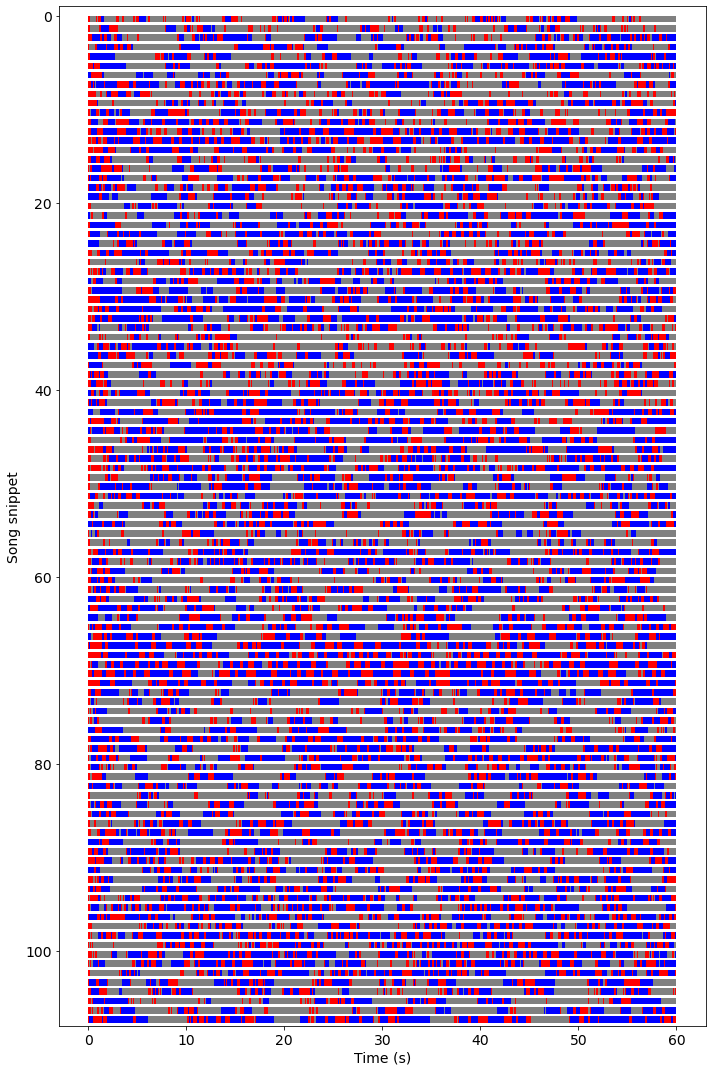

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 15), tight_layout=True)
for csng, sng in enumerate(sngs_all):
    plot_b(ax, t, sng, [0, t.max(), csng, csng+.7], c=['gray', 'b', 'r'])
    
set_plot(ax, y_lim=(nsng, -1), x_label='Time (s)', y_label='Song snippet', font_size=14)

In [6]:
# neural params
params = {
    'TAU_R': np.array([30, 60]),
    'TAU_A': np.array([2, 1]),
    'X_S': np.array([.5, .5]),
    'X_P': np.array([.5, .5]),
}

In [7]:
b_nats = [sngs_all[12], sngs_all[18]]
i_s_nats = [(b_nat == 1).astype(float) for b_nat in b_nats]
i_p_nats = [(b_nat == 2).astype(float) for b_nat in b_nats]

t = np.arange(len(b_nats[0]))*DT

In [13]:
# pure sine
i_s_s = np.ones(len(t))
i_p_s = np.zeros(len(t))

b_s = 0*t
b_s[i_s_s == 1] = 1

# pure pulse
i_s_p = np.zeros(len(t))
i_p_p = np.ones(len(t))

b_p = 0*t
b_p[i_p_p == 1] = 2

d_gap = 20
i_gap = np.zeros(int(round(d_gap/DT)))
b_gap = np.zeros(int(round(d_gap/DT)))

i_ss = [i_gap, i_s_p, i_gap, i_s_nats[0], i_gap]
i_ps = [i_gap, i_p_p, i_gap, i_p_nats[0], i_gap]
bs = [b_gap, b_p, b_gap, b_nats[0], b_gap]

i_s = cc(i_ss)
i_p = cc(i_ps)
b = cc(bs)

rs_lnma = smlt_lnma(i_s, i_p, params, DT)
rs_ma = smlt_ma(i_s, i_p, params, DT)

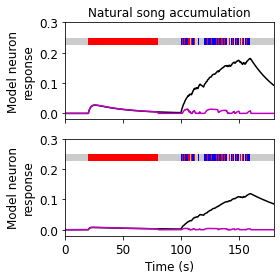

In [21]:
fig, axs = plt.subplots(2, 1, figsize=(4, 4), tight_layout=True, sharex=True, sharey=True)

t_full = DT*np.arange(len(b))

for cax, ax in enumerate(axs):

    ax.plot(t_full, rs_ma[:, cax], c='k')
    ax.plot(t_full, rs_lnma[:, cax], c='m')
    if ax is axs[0]:
        ax.set_title('Natural song accumulation')
#         ax.legend(['MA', 'LN'], loc='center right')
    if ax is axs[-1]:
        set_plot(ax, x_label='Time (s)')
        
    plot_b(ax, t_full, b, extent=[t_full[0], t_full[-1]+DT, .225, .25], c=[(.8, .8, .8), 'b', 'r'])
    set_plot(ax, x_lim=(0, t_full[-1]+DT), y_lim=(-.02, .3), y_label='Model neuron\nresponse', font_size=12)

fig.savefig('simons_2023/fig_3d.svg')